data from https://www.kaggle.com/vikramb/mobile-price-eda-prediction

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import GridSearchCV

In [5]:
all_data = pd.read_csv('data.csv')
train_data, test_data = train_test_split(all_data, test_size=1/3, random_state=10)

In [11]:
numeric_cols = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt',
                'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']
cat_cols = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
feat_cols = numeric_cols + cat_cols
label_col = 'price_range'


trn_cat_feats = train_data[cat_cols].values
tes_cat_feats = test_data[cat_cols].values


trn_numeric_feats = train_data[numeric_cols]
tes_numeric_feats = test_data[numeric_cols]


enc = OneHotEncoder(sparse=False)
enc_trn_cat_feats = enc.fit_transform(trn_cat_feats)
enc_tes_cat_feats = enc.transform(tes_cat_feats)

trn_all_feats = np.hstack((trn_numeric_feats, enc_trn_cat_feats))
tes_all_feats = np.hstack((tes_numeric_feats, enc_tes_cat_feats))

std_scaler = StandardScaler()
scaled_trn_all_feats = std_scaler.fit_transform(trn_all_feats)
scaled_tes_all_feats = std_scaler.transform(tes_all_feats)


X_train = scaled_trn_all_feats

X_test = scaled_tes_all_feats

In [12]:
y_train = train_data[label_col].values
y_test = test_data[label_col].values

In [13]:
def train_model(X_train, y_train, X_test, y_test, model_name, model, param_range):

    clf = GridSearchCV(estimator=model,
                       param_grid=param_range,
                       cv=5,
                       scoring='accuracy',
                       refit=True)
    start = time.time()
    clf.fit(X_train, y_train)

    end = time.time()
    duration = end - start
    print('used {:.4f}s'.format(duration))

    print('train acc：{:.3f}'.format(clf.score(X_train, y_train)))

    score = clf.score(X_test, y_test)
    print('test acc：{:.3f}'.format(score))
    print('time used: {:.4f}s'.format(duration))
    print()

    return clf, score, duration

used 1.1173s
train acc：0.628
test acc：0.565
time used: 1.1173s

used 0.2520s
train acc：0.879
test acc：0.841
time used: 0.2520s

used 2.0596s
train acc：0.988
test acc：0.973
time used: 2.0596s

used 0.1290s
train acc：1.000
test acc：0.796
time used: 0.1290s

used 114.5239s
train acc：0.998
test acc：0.831
time used: 114.5239s

used 6.4829s
train acc：0.704
test acc：0.654
time used: 6.4829s

used 18.2832s
train acc：1.000
test acc：0.885
time used: 18.2832s

used 9.4494s
train acc：1.000
test acc：0.853
time used: 9.4494s


===================== model results =====================


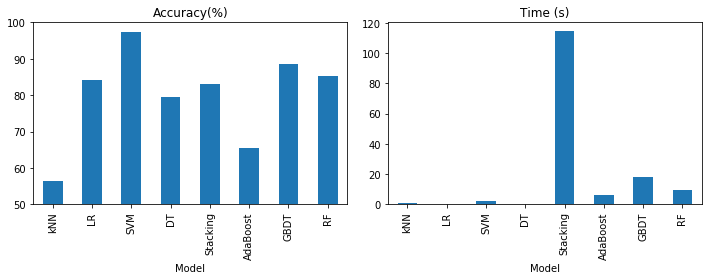

In [15]:


sclf = StackingClassifier(classifiers=[KNeighborsClassifier(),
                                       SVC(kernel='linear'),
                                       DecisionTreeClassifier()],
                          meta_classifier=LogisticRegression())

model_name_param_dict = {'kNN': (KNeighborsClassifier(),
                                 {'n_neighbors': [5, 25, 55]}),
                         'LR': (LogisticRegression(),
                                {'C': [0.01, 1, 100]}),
                         'SVM': (SVC(kernel='linear'),
                                 {'C': [0.01, 1, 100]}),
                         'DT': (DecisionTreeClassifier(),
                                {'max_depth': [50, 100, 150]}),
                         'Stacking': (sclf,
                                      {'kneighborsclassifier__n_neighbors': [5, 25, 55],
                                       'svc__C': [0.01, 1, 100],
                                       'decisiontreeclassifier__max_depth': [50, 100, 150],
                                       'meta-logisticregression__C': [0.01, 1, 100]}),
                         'AdaBoost': (AdaBoostClassifier(),
                                      {'n_estimators': [50, 100, 150, 200]}),
                         'GBDT': (GradientBoostingClassifier(),
                                  {'learning_rate': [0.01, 0.1, 1, 10, 100]}),
                         'RF': (RandomForestClassifier(),
                                {'n_estimators': [100, 150, 200, 250]})}

results_df = pd.DataFrame(columns=['Accuracy (%)', 'Time (s)'],
                          index=list(model_name_param_dict.keys()))
results_df.index.name = 'Model'

for model_name, (model, param_range) in model_name_param_dict.items():
    best_clf, best_acc, mean_duration = train_model(X_train, y_train, X_test, y_test,
                                                    model_name, model, param_range)
    results_df.loc[model_name, 'Accuracy (%)'] = best_acc * 100
    results_df.loc[model_name, 'Time (s)'] = mean_duration

print('\n===================== model results =====================')

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
results_df.plot(y=['Accuracy (%)'], kind='bar', ylim=[50, 100], ax=ax1, title='Accuracy(%)', legend=False)

ax2 = plt.subplot(1, 2, 2)
results_df.plot(y=['Time (s)'], kind='bar', ax=ax2, title='Time (s)', legend=False)
plt.tight_layout()
plt.show()
